# Quick Run on the State of Things

Here, I will walk through on a simple computational modelling use-case to demonstrate the modular characteristics of the toolbox, `cpm` (Computational Psychiatry Modelling) library.

The general structure of the toolbox is as follows:

- cpm.applications : contains fully-fledged and ready-to-use models (Delta-Rule or Least Mean Square network, Q-learning algorithm, Actor-Critic, ...).
- cpm.models : contains the core classes for running and wrapping the models (simulator, wrapper).
- cpm.components : contains the core classes for the components of the models (q-learning rule, delta rule, softmax, winner-takes-all).
- cpm.optimization : contains the core classes for the optimization of the models (differential evolution, bayesian mcmc, ...).
- cpm.evaluate : contains the core classes for the evaluation of the models (parameter recovery, model recovery).
- cpm.utils : contains the core classes for the utilities of the models (convert from pandas to dict and vica versa, ...).

### Creating Models

First, users must stitch together their model as a function.
Each model is a function that takes in a dictionary that includes the parameters and the state, and returns a dictionary of outputs.
The keys for each dictionary must include the variable names as defined for the already existing components in the toolbox and must be consistent with the variable names used in the model.
In addition, each output must contain a `values` and `policy` keys, which are the main thing we pull out of the model across all different routines we implement.

In [1]:
from cpm.generators import Parameters, Wrapper
# import components we want to use

# import components we want to use
from cpm.models.utils import Nominal
from cpm.models.learning import DeltaRule

# import some useful stuff
from prettyformatter import pprint as pp ## pretty print
import numpy as np


Here, we will create a model with a single activation component, a single decision component, and a single learning component.
This will be the model that we iterate over each trial, which means that this compiled model will only calculate the output for a single trial.

The main advantage of using a dictionary is that you can feed the same thing to x number of models without any issues, because each pulls out the relevant information from the dictionary.

This makes things easier for model comparisons, especially for us with the model recovery that we are implementing in the future.

In [2]:
## create a single trial as a dictionary
trial = {
    "trials": np.array([1, 2]),
    "feedback": np.array([1]),
    "attention": np.array([1, 0]), ## not used in the model
    "misc": np.array([1, 0]),      ## not used in the model
}

## create a set of parameters
## the parameter class is only used for the Wrapper
## other classes and modules will convert the parameters to this class automatically 
parameters = Parameters(alpha=0.1, temperature=1, values=np.array([[-0.5, 0.7, 0.9, 0]]))


Parameter must have their own class, because we plan to integrate parameter bounds and priors into this class, which can then be used across the toolbox.
The thing is that priors and bounds should also be part of the model specifications, so I reckon it needs more thought before we proceed.

Below, we can define our terrible mock model.

In [3]:
def model(parameters, trial):
    ## import parameters
    alpha = parameters.alpha
    temperature = parameters.temperature
    ## import variables
    weights = parameters.values

    ## import trial
    stimulus = trial.get("trials")
    stimulus = Nominal(target=stimulus, bits=4)
    feedback = trial.get("feedback")

    ## specify the computations for a given trial
    ## multiply weights with stimulis vector
    active = stimulus * weights
    ## this is a mock-up policy
    policy = np.sum(active) * temperature
    ## learning
    learning = DeltaRule(
        weights=active, feedback=feedback, alpha=alpha, input=stimulus
    )
    learning.compute()
    error = learning.weights
    weights += error
    output = {
        "policy": np.array([policy]),
        "values": weights,
        "dependent": np.array([policy]),
    }
    return output

This is a very simple model with some very simple components and output.
We can also export some details about the model to learn what is going on under the hood.
This is where we need to store all metadata as well (including bounds and priors - not yet implemented).
Let's see how it works.

In [4]:
model(parameters, trial)

{'policy': array([0.2]),
 'values': array([[-0.42,  0.78,  0.9 ,  0.  ]]),
 'dependent': array([0.2])}

### Run the model on data

Let us start by defining some parameters.
We will define them in a dictionary, which allows the Model and Wrapper classes to pull the parameters they need by name.
So you don't have to create different objects for each model, you can simply input the same dictionary to all models and they will pull the parameters they need.
You don't even need to subset them.

The next bit will be defining the experiment.
Currently, we use dictionaries, but there is no reason why we can't use pandas dataframes with our own conversion.
Again, the goal is that when you have any type of routine, models and actually anything can pull the information they need from the same object using the `keys` in the dictionary.
If we were to use arrays or lists, indexing would be a pain.

It will require a bit of explanations so here we go.

The experiment is a dictionary that contains all the information about the experiment that the **model** needs to run.
Some models will require more information than others, but the basic information is the same.

- `trials`: It is a 2D array where the first dimension represents the trial and the second dimension represents for example in which order the stimuli is presented. If you have stimulus 2 and stimulus 3 presented on trial 1, then the first row will be `[2, 3]`. If you have stimulus 1 and stimulus 3 presented on trial 2, then the second row will be `[1, 3]`. This will look like `[[2, 3], [1, 3]]` This is the only thing that is required for all models.
- `feedback`: It is (currently) a 1D array where the first dimension represents the trial and the value represents the feedback. If you have feedback 1 on trial 1 and feedback 0 on trial 2, then the array will be `[1, 0]`. This will look like `[1, 0]`. This is required for all models that have a learning component.

Keep in mind that this type of representation will largely depend on the type of model users will implement.

In [5]:
data = {
    "trials": np.array(
        [[2, 3], [1, 4], [3, 2], [4, 1], [2, 3], [2, 3], [1, 4], [3, 2], [4, 1], [2, 3]]
    ),
    "feedback": np.array([[1], [0], [1], [0], [1], [1], [0], [1], [0], [1]]),
}

The next bit that we can do is to use the `Wrapper` class to run the model on our experiment, like it was a participant.
This object will take in the model, the parameters, and the experiment and will run the model on the experiment using the parameters.

In [6]:
# Add new parameters to the model
params = {
    "alpha": 0.4,
    "temperature": 1,
    "values": np.zeros((1, 4)),
}

params = Parameters(**params)

wrap = Wrapper(model=model, parameters=params, data=data)
wrap.run()
wrap.dependent

array([[0.     ],
       [0.     ],
       [0.8    ],
       [0.     ],
       [0.96   ],
       [0.992  ],
       [0.     ],
       [0.9984 ],
       [0.     ],
       [0.99968]])

Awesome.
We can also use the export function to export the model output with the parameters to a dictionary.
The main difference between `export()` and `summary()` is that in the long run `export()` will contain more metadata and will allow to export to a JSON file.

In [7]:
pp(wrap.export())


   policy_0  values_0  values_1  values_2  values_3  dependent_0  ppt
0   0.00000       0.0  0.400000  0.400000       0.0      0.00000    0
0   0.00000       0.0  0.400000  0.400000       0.0      0.00000    0
0   0.80000       0.0  0.480000  0.480000       0.0      0.80000    0
0   0.00000       0.0  0.480000  0.480000       0.0      0.00000    0
0   0.96000       0.0  0.496000  0.496000       0.0      0.96000    0
0   0.99200       0.0  0.499200  0.499200       0.0      0.99200    0
0   0.00000       0.0  0.499200  0.499200       0.0      0.00000    0
0   0.99840       0.0  0.499840  0.499840       0.0      0.99840    0
0   0.00000       0.0  0.499840  0.499840       0.0      0.00000    0
0   0.99968       0.0  0.499968  0.499968       0.0      0.99968    0


Now, we can also reset the model and run it again with different parameters.


In [8]:
wrap.reset(parameters={"alpha": 0.05, "temperature": 1, "values": np.zeros((1, 4))})
wrap.run()
pp(wrap.export())

   policy_0  values_0  values_1  values_2  values_3  dependent_0  ppt
0   0.00000       0.0  0.050000  0.050000       0.0      0.00000    0
0   0.00000       0.0  0.050000  0.050000       0.0      0.00000    0
0   0.10000       0.0  0.095000  0.095000       0.0      0.10000    0
0   0.00000       0.0  0.095000  0.095000       0.0      0.00000    0
0   0.19000       0.0  0.135500  0.135500       0.0      0.19000    0
0   0.27100       0.0  0.171950  0.171950       0.0      0.27100    0
0   0.00000       0.0  0.171950  0.171950       0.0      0.00000    0
0   0.34390       0.0  0.204755  0.204755       0.0      0.34390    0
0   0.00000       0.0  0.204755  0.204755       0.0      0.00000    0
0   0.40951       0.0  0.234280  0.234280       0.0      0.40951    0


Now, let us save the model. Each object will have a save method that will save the object to a file. We use `pickle` to write the object to a disk.

In [9]:
wrap.simulation

[{'policy': array([0.]),
  'values': array([[0.  , 0.05, 0.05, 0.  ]]),
  'dependent': array([0.])},
 {'policy': array([0.]),
  'values': array([[0.  , 0.05, 0.05, 0.  ]]),
  'dependent': array([0.])},
 {'policy': array([0.1]),
  'values': array([[0.   , 0.095, 0.095, 0.   ]]),
  'dependent': array([0.1])},
 {'policy': array([0.]),
  'values': array([[0.   , 0.095, 0.095, 0.   ]]),
  'dependent': array([0.])},
 {'policy': array([0.19]),
  'values': array([[0.    , 0.1355, 0.1355, 0.    ]]),
  'dependent': array([0.19])},
 {'policy': array([0.271]),
  'values': array([[0.     , 0.17195, 0.17195, 0.     ]]),
  'dependent': array([0.271])},
 {'policy': array([0.]),
  'values': array([[0.     , 0.17195, 0.17195, 0.     ]]),
  'dependent': array([0.])},
 {'policy': array([0.3439]),
  'values': array([[0.      , 0.204755, 0.204755, 0.      ]]),
  'dependent': array([0.3439])},
 {'policy': array([0.]),
  'values': array([[0.      , 0.204755, 0.204755, 0.      ]]),
  'dependent': array([0.])},

In [10]:
wrap.save(filename = "test")

### Optimisation

Now we have the model we want to use.
Let's create some data to fit the model to.

I implemented some utility functions, where you can convert from pandas to arrays of dictionaries and vice versa.
It will require more thought and standardisation, but it is a start.

In [11]:
experiment = []
for i in range(100):
    ppt = {
        "ppt": i,
        "trials": np.array(
            [
                [2, 3],
                [1, 4],
                [3, 2],
                [4, 1],
                [2, 3],
                [2, 3],
                [1, 4],
                [3, 2],
                [4, 1],
                [2, 3],
            ]
        ),
        "feedback": np.array([[1], [0], [1], [0], [1], [1], [0], [1], [0], [1]]),
        "observed": np.array([[1], [0], [1], [0], [1], [1], [0], [1], [0], [1]]),
    }
    experiment.append(ppt)


Compared to running the model on data, this is a bit more complicated.
Here we need to create a list of dictionaries, where each dictionary represents a single experiment a.k.a. a single participant.
Here I added two new key-value pairs to the experiment dictionary: `ppt` and `observed`.
`ppt` is the participant ID and `observed` is the observed response on each trial.
It must be in the format the model outputs the policies: a 2D array where the first dimension represents the trial and the second dimension represents the action.
So they are essentially ones and zeros, because participants make binary decisions.

Okay, let's optimise the model.
We will use the `DifferentialEvolution` class to do so, and will use an Evolutionary/genetic algorithm from `scipy`.
The optimiser will take in the wrapper, the data, and the bounds (it will be part of the model specification later).
It takes in some pre-defined arguments, but anything else passed to it will be passed to the `scipy` optimiser.

Here, our goal is to organise the optimisation routines in a way that they are easy to use and easy to understand for the type of uses we have in mind or others have in mind.
That is to fit each model to each participant.

Now, here the data will also include trial-level details, such as the stimuli and feedback.
The main reason is that we fit trial-level observations for each participants, because we fit them to each participant.


In [12]:
from cpm.optimisation import DifferentialEvolution, minimise

lower = [1e-10, 1e-10]
upper = [1, 1]
bounds = list(zip(lower, upper))

Fit = DifferentialEvolution(
    model=wrap,
    bounds=bounds,
    data=experiment,
    minimisation=minimise.LogLikelihood, # currently, this is the only working metric
    mutation=0.5, # kwargs
    recombination=0.7, # kwargs
    strategy="best1bin", # kwargs
    tol=0.1, # kwargs
    maxiter=200, # kwargs
)  # initialize the optimisation

Fit.optimise()

pp(Fit.fit)

[
    {"parameters": array([0.49999831, 1.        ]), "fun": 9.689385332052415},
    {"parameters": array([0.50000082, 0.999999  ]), "fun": 9.689385332048932},
    {"parameters": array([0.5000003, 1.       ]), "fun": 9.68938533204691},
    {"parameters": array([0.50000171, 1.        ]), "fun": 9.689385332052554},
    {"parameters": array([0.50000039, 1.        ]), "fun": 9.68938533204703},
    ...,
    {"parameters": array([0.49999996, 1.        ]), "fun": 9.68938533204673},
    {"parameters": array([0.50000076, 1.        ]), "fun": 9.68938533204788},
    {"parameters": array([0.49999999, 1.        ]), "fun": 9.689385332046726},
]


We can also look at the best fitting parameters here.
In principle, they should be the same because right new all participants are the same.

In [13]:
pp(Fit.parameters)

[
    {"alpha": 0.4999983134910619, "temperature": 1.0},
    {"alpha": 0.5000008179430346, "temperature": 0.9999989990247891},
    {"alpha": 0.5000003044062573, "temperature": 1.0},
    {"alpha": 0.5000017070184456, "temperature": 1.0},
    {"alpha": 0.5000003896139673, "temperature": 1.0},
    ...,
    {"alpha": 0.49999996385022005, "temperature": 1.0},
    {"alpha": 0.5000007599934907, "temperature": 1.0},
    {"alpha": 0.49999999287541425, "temperature": 1.0},
]


In [14]:
Fit.export()

,alpha,temperature,fun
0,0.499998,1.000000,9.689385
0,0.500001,0.999999,9.689385
0,0.500000,1.000000,9.689385
0,0.500002,1.000000,9.689385
0,0.500000,1.000000,9.689385
...,...,...,...
0,0.500000,1.000000,9.689385
0,0.500000,1.000000,9.689385
0,0.500000,1.000000,9.689385
0,0.500001,1.000000,9.689385


In [15]:
Fit.details

[{'x': array([0.49999831, 1.        ]),
  'fun': 9.689385332052415,
  'nfev': 75,
  'nit': 1,
  'message': 'Optimization terminated successfully.',
  'success': True,
  'jac': array([-6.75015599e-06, -3.37507798e-06])},
 {'x': array([0.50000082, 0.999999  ]),
  'fun': 9.689385332048932,
  'nfev': 78,
  'nit': 1,
  'message': 'Optimization terminated successfully.',
  'success': True,
  'jac': array([ 1.24344978e-06, -3.19744229e-06])},
 {'x': array([0.5000003, 1.       ]),
  'fun': 9.68938533204691,
  'nfev': 78,
  'nit': 1,
  'message': 'Optimization terminated successfully.',
  'success': True,
  'jac': array([1.24344978e-06, 5.32907049e-07])},
 {'x': array([0.50000171, 1.        ]),
  'fun': 9.689385332052554,
  'nfev': 78,
  'nit': 1,
  'message': 'Optimization terminated successfully.',
  'success': True,
  'jac': array([6.75015596e-06, 3.37507798e-06])},
 {'x': array([0.50000039, 1.        ]),
  'fun': 9.68938533204703,
  'nfev': 78,
  'nit': 1,
  'message': 'Optimization termina

This is great, so noew we can run the model on the best fitting parameters and see how it looks like.
We can use the `Simulator` class to do that, which takes in the data as defined above a list of dictionaries for the parameter.
I know that the Simulator was used a bit differently in what we outlined in the Engineering Document, but I think that this is still okay for now.

In [16]:
from cpm.generators import Simulator

wrap.reset()

explore = Simulator(model = wrap, data = experiment, parameters = Fit.parameters)
explore.run()


In [17]:
explore.simulation

array([[{'policy': array([0.]), 'values': array([[0.        , 0.49999831, 0.49999831, 0.        ]]), 'dependent': array([0.])},
        {'policy': array([0.]), 'values': array([[0.        , 0.49999831, 0.49999831, 0.        ]]), 'dependent': array([0.])},
        {'policy': array([0.99999663]), 'values': array([[0. , 0.5, 0.5, 0. ]]), 'dependent': array([0.99999663])},
        {'policy': array([0.]), 'values': array([[0. , 0.5, 0.5, 0. ]]), 'dependent': array([0.])},
        {'policy': array([1.]), 'values': array([[0. , 0.5, 0.5, 0. ]]), 'dependent': array([1.])},
        {'policy': array([1.]), 'values': array([[0. , 0.5, 0.5, 0. ]]), 'dependent': array([1.])},
        {'policy': array([0.]), 'values': array([[0. , 0.5, 0.5, 0. ]]), 'dependent': array([0.])},
        {'policy': array([1.]), 'values': array([[0. , 0.5, 0.5, 0. ]]), 'dependent': array([1.])},
        {'policy': array([0.]), 'values': array([[0. , 0.5, 0.5, 0. ]]), 'dependent': array([0.])},
        {'policy': array([1.

In [18]:
explore.export()

,policy_0,values_0,values_1,values_2,values_3,dependent_0,ppt
0,0.000000,0.0,0.499998,0.499998,0.0,0.000000,0
0,0.000000,0.0,0.499998,0.499998,0.0,0.000000,0
0,0.999997,0.0,0.500000,0.500000,0.0,0.999997,0
0,0.000000,0.0,0.500000,0.500000,0.0,0.000000,0
0,1.000000,0.0,0.500000,0.500000,0.0,1.000000,0
...,...,...,...,...,...,...,...
0,1.000000,0.0,0.500000,0.500000,0.0,1.000000,99
0,0.000000,0.0,0.500000,0.500000,0.0,0.000000,99
0,1.000000,0.0,0.500000,0.500000,0.0,1.000000,99
0,0.000000,0.0,0.500000,0.500000,0.0,0.000000,99


In [19]:
explore.simulation[0][5:15]

array([{'policy': array([1.]), 'values': array([[0. , 0.5, 0.5, 0. ]]), 'dependent': array([1.])},
       {'policy': array([0.]), 'values': array([[0. , 0.5, 0.5, 0. ]]), 'dependent': array([0.])},
       {'policy': array([1.]), 'values': array([[0. , 0.5, 0.5, 0. ]]), 'dependent': array([1.])},
       {'policy': array([0.]), 'values': array([[0. , 0.5, 0.5, 0. ]]), 'dependent': array([0.])},
       {'policy': array([1.]), 'values': array([[0. , 0.5, 0.5, 0. ]]), 'dependent': array([1.])}],
      dtype=object)

Let's look at the output.
We can simply export the outcome as a pandas dataframe and plot it.
It is confusingly names `export()`, so that will need to be changed.

### Evaluation

Alright, let us now try to do some parameter recovery.
There is less and less thing to explain now, so I will just go through it quickly.

We will use the `ParameterRecovery` from `cpm.evaluation`.
This will take in the Wrapper, the optimiser, the strategy, bounds, and iterations.

Okay, that was fairly quick.
Let's look at the results for the learning rate, which we can simply extract from the `ParameterRecovery` object.
NOTE that the model will have bad performance, but let's ignore that for now and focus on functionalities.

In [20]:
explore.generate()
explore.generated[0].get("observed").shape

(10, 1)

In [21]:
from cpm.evaluation import ParameterRecovery, strategies


new = Simulator(model = wrap, data = experiment, parameters = Fit.parameters)

recover = ParameterRecovery(
    model = new,
    strategy = strategies.grid,
    optimiser = DifferentialEvolution, 
    loss=minimise.LogLikelihood,
    iteration = 10, bounds = bounds, tol = 0.1, maxiter = 200
    )

recover.recover()



In [22]:
recover.extract(key="alpha")

,recovered,original,fit,iteration
0,0.051204,0.050460,9.189385,0
1,0.705568,0.705562,9.189385,0
2,0.354691,0.354693,9.189385,0
3,0.381168,0.381173,9.189385,0
4,0.639981,0.639986,9.189385,0
...,...,...,...,...
95,0.245326,0.245312,9.189385,9
96,0.851801,0.851801,9.189385,9
97,0.030011,0.006839,9.189388,9
98,0.010454,0.090178,9.189399,9


In [23]:
import matplotlib.pyplot as plt

alpha = recover.extract(key = 'alpha')
alpha["ppt"] = np.repeat(np.arange(100), 10)


<Axes: xlabel='recovered', ylabel='original'>

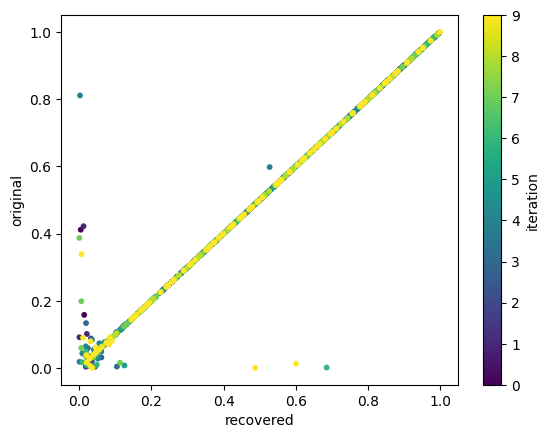

In [24]:
alpha.plot.scatter(x="recovered", y="original", c="iteration", colormap="viridis", s = 10)

## The END

That's it for now.
There are some things that don't work as expected, but I am actively looking into them.
I think the biggest challenge was the modular aspect of the toolbox, but I think that it is working quite well now.